In [1]:
import sys
import warnings

sys.path.append("../../")
warnings.filterwarnings("ignore")

# set working directory to root 
import os
os.chdir("../../")
root = os.getcwd()
# root = root + "/workspaces/mine-segmentation" # for lightning studios
print(f"Root directory: {root}")

Root directory: /teamspace/studios/this_studio/workspaces/mine-segmentation


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
# import leafmap
import torch
import torch.nn.functional as F
# from einops import rearrange
# from matplotlib.colors import ListedColormap
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, recall_score, precision_score, roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import contextily as ctx
# from shapely.wkt import loads
# import datetime
from pathlib import Path
import random
import shutil
import os

from src.models.datamodule import MineDataModule
from src.models.cnn.model import MineSegmentorCNN
from src.models.clay.segment.model import MineSegmentor

from src.data.get_satellite_images import ReadSTAC

from src.visualization.visualization_funcs import plot_pred_vs_true_mask

In [3]:
# for development
%load_ext autoreload
%autoreload 2

In [4]:
# 512 model
MINESEG_CHECKPOINT_PATH = ("models/cnn/mineseg-cnn_epoch-21_val-iou-0.5826.ckpt")
CHIP_SIZE = 512
TESTSET_BATCH_SIZE = 16 # 32 for L4, 16 for PC GPU
TRAIN_CHIP_DIR = "data/processed/chips/npy/512/train/chips/"
TRAIN_LABEL_DIR = "data/processed/chips/npy/512/train/labels/"
VAL_CHIP_DIR = "data/processed/chips/npy/512/val/chips/"
VAL_LABEL_DIR = "data/processed/chips/npy/512/val/labels/"
VALIDATION_CHIP_DIR = "data/processed/chips/npy/512/validation/chips/"
VALIDATION_LABEL_DIR = "data/processed/chips/npy/512/validation/labels/"
METADATA_PATH = "configs/cnn/cnn_segment_metadata.yaml"
CLAY = False


# general setup
DATASET = "data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg"
BATCH_SIZE = 1
if torch.cuda.is_available():
    NUM_WORKERS = 16
else:
    NUM_WORKERS = 4
PLATFORM = "sentinel-2-l2a"

In [5]:
if CLAY:
    CLAY_CHECKPOINT_PATH = root + "/" + CLAY_CHECKPOINT_PATH

MINESEG_CHECKPOINT_PATH = root + "/" + MINESEG_CHECKPOINT_PATH
METADATA_PATH = root + "/" + METADATA_PATH
TRAIN_CHIP_DIR = root +  "/" + TRAIN_CHIP_DIR
TRAIN_LABEL_DIR = root + "/" + TRAIN_LABEL_DIR
VAL_CHIP_DIR = root + "/" + VAL_CHIP_DIR
VAL_LABEL_DIR = root + "/" + VAL_LABEL_DIR
VALIDATION_CHIP_DIR = root + "/" + VALIDATION_CHIP_DIR
VALIDATION_LABEL_DIR = root + "/" + VALIDATION_LABEL_DIR
DATASET = root + "/" + DATASET

In [6]:
model_name = MINESEG_CHECKPOINT_PATH.split("/")[-1]
print(f"Using model {model_name}")
print(f"Using chip size {CHIP_SIZE}")
print(f"Using validation chip dir {VALIDATION_CHIP_DIR}")
print(f"Using test batch size {TESTSET_BATCH_SIZE}")
print(f"Using dataset {DATASET}")


Using model mineseg-cnn_epoch-21_val-iou-0.5826.ckpt
Using chip size 512
Using validation chip dir /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/chips/npy/512/validation/chips/
Using test batch size 16
Using dataset /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg


#### Model Loading

In [7]:
if CLAY:
    def get_model(mineseg_checkpoint_path, clay_checkpoint_path, metadata_path):
        model = MineSegmentor.load_from_checkpoint(
            checkpoint_path=mineseg_checkpoint_path,
            metadata_path=metadata_path,
            ckpt_path=clay_checkpoint_path,
        )
        model.eval()
        return model
else: 
    def get_model(checkpoint_path: str) -> MineSegmentorCNN:
        # check if gpu is available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        map_location=torch.device(device)
        checkpoint = torch.load(checkpoint_path, map_location=map_location)
        model_config = checkpoint["hyper_parameters"]
        model = MineSegmentorCNN.load_from_checkpoint(checkpoint_path, **model_config)
        model.eval()
        return model

## Downloading full S2 Scene

In [8]:
# search on planetary computer for tile id that you like
tile_id = "S2B_MSIL2A_20240823T033539_R061_T50VMM_20240823T082315"

# Download the image 
api_url="https://planetarycomputer.microsoft.com/api/stac/v1"
bands = ['B04', 'B03', 'B02', 'B08']

stac_reader = ReadSTAC(api_url=api_url, collection = "sentinel-2-l2a")

item = stac_reader.get_item_by_name(tile_id)

# read as stack
stack = stac_reader.get_stack(
    items=item, 
    bands=bands,
    crop_to_bounds=False, 
    squeeze_time_dim=True,
    # custom_point_and_buffer=[lon, lat, 10240],
    chunk_size=512,
    )

# save geotiff
file_path = f"data/interim/{tile_id}.tif"
stac_reader.save_stack_as_geotiff(stack, file_path)

Loading stack...
Returning stack from single S2 image with ID: S2B_MSIL2A_20240823T033539_R061_T50VMM_20240823T082315
Saving stack as GeoTIFF under: data/interim/S2B_MSIL2A_20240823T033539_R061_T50VMM_20240823T082315.tif


In [9]:
stack

<xarray.DataArray 'stackstac-973a732734095927482372894f2b7923' (band: 4,
                                                                y: 10980,
                                                                x: 10980)> Size: 2GB
dask.array<mosaic-aggregate, shape=(4, 10980, 10980), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * band                                     (band) <U3 48B 'B04' ... 'B08'
  * x                                        (x) float64 88kB 4e+05 ... 5.098...
  * y                                        (y) float64 88kB 6.7e+06 ... 6.5...
    eo:cloud_cover                           float64 8B 0.3145
    instruments                              <U3 12B 'msi'
    s2:product_type                          <U7 28B 'S2MSI2A'
    ...                                       ...
    proj:shape                               object 8B {10980}
    common_name                              (band) <U5 80B 'red' ... 'nir'
    center_wavelength                        (band) float64 32B 0.665 ... 0.842
    full_width_half_max                      (band) float64 32B 0.038 ... 0.145
    epsg                                     int64 8B 32650
    s2_tile_id                               <U54 216B 'S2B_MSIL2A_20240823T0...
Attributes:
    spec:        RasterSpec(epsg=32650, bounds=(399960, 6590220, 509760, 6700...
    crs:         epsg:32650
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 6700020.00|\n| 0.0...
    resolution:  10
    s2_tile_id:  S2B_MSIL2A_20240823T033539_R061_T50VMM_20240823T082315

## Chipping

In [10]:
from src.data.make_chips import read_and_chip

# check if validation dir exists, and if it does, delete it
if os.path.exists("data/processed/chips/npy/512/validation/"):
    shutil.rmtree("data/processed/chips/npy/512/validation/")

output_dir = "data/processed/chips/npy/512/validation/chips/"

read_and_chip(
    file_path=file_path, 
    chip_size=512, 
    output_dir=output_dir, 
    chip_format="npy"
    )

In [11]:
# create a label file for the chip

import os
import numpy as np

chip_dir = "data/processed/chips/npy/512/validation/chips/"
label_dir = "data/processed/chips/npy/512/validation/labels/"

# Create the label directory if it doesn't exist
os.makedirs(label_dir, exist_ok=True)

# Get the list of chip files
chip_files = os.listdir(chip_dir)

# Create the corresponding mask files
for chip_file in chip_files:
    chip_path = os.path.join(chip_dir, chip_file)
    label_file = chip_file.replace("chip", "chip")
    label_path = os.path.join(label_dir, label_file)
    
    # Create a 512x512 numpy array with all 0s
    label = np.zeros((512, 512,1))
    
    # Save the label array as a numpy file
    np.save(label_path, label)

## Prediction

#### Data Prep

In [12]:
def get_data(
    train_chip_dir,
    train_label_dir,
    val_chip_dir,
    val_label_dir,
    test_chip_dir,
    test_label_dir,
    metadata_path,
    batch_size,
    num_workers,
    platform,
    data_augmentation,
    index=None
):
    dm = MineDataModule(
        train_chip_dir=train_chip_dir,
        train_label_dir=train_label_dir,
        val_chip_dir=val_chip_dir,
        val_label_dir=val_label_dir,
        test_chip_dir=test_chip_dir,
        test_label_dir=test_label_dir,
        metadata_path=metadata_path,
        batch_size=batch_size,
        num_workers=num_workers,
        platform=platform,
        data_augmentation=data_augmentation,
    )
    
    dm.setup(stage="test")
    
    if index is not None:
        test_dl = iter(dm.test_dataloader())
        for i in range(index + 1):
            batch = next(test_dl)
        metadata = dm.metadata
        return batch, metadata
    else:
        test_dl = dm.test_dataloader()
        batch = next(iter(test_dl))
        metadata = dm.metadata
        return batch, metadata

In [13]:
def post_process(batch, outputs, metadata, index=0):
    
    outputs = outputs.sigmoid()
    prob_mask = outputs.cpu().numpy()
    pred_mask = (prob_mask > 0.5).astype(float)
    labels = batch["label"].detach().cpu().numpy()
    pixels = batch["pixels"].detach().cpu().numpy()

    # reduce pixel dimension to only 3 channels if required
    if pixels.shape[1] > 3:
        pixels = pixels[:, :3, :, :]

    # normalize and clip the image ranges
    pixels = (pixels - pixels.min()) / (pixels.max() - pixels.min())
    pixels = np.clip(pixels, 0, 1)

    images = pixels[index]
    labels = labels[index]
    prob_mask = prob_mask[index]
    pred_mask = pred_mask[index].astype(float)

    images = images.transpose((1,2,0))
    prob_mask = prob_mask.transpose((1,2,0))
    pred_mask = pred_mask.transpose((1,2,0)).astype(float)

    # normalize the probablity mask
    # prob_mask = (prob_mask - prob_mask.min()) / (prob_mask.max() - prob_mask.min())

    return images, labels, prob_mask, pred_mask

In [14]:
def plot_predictions(images, labels, probas, preds):
    fig, axes = plt.subplots(1, 5, figsize=(15, 6))

    # Plot the image
    axes[0].imshow(images)
    axes[0].axis("off")
    axes[0].set_title("Image", fontsize=12)

    # Plot the actual segmentation
    axes[1].imshow(labels, vmin=0, vmax=1)
    axes[1].axis("off")
    axes[1].set_title("Actual", fontsize=12)

    # Plot the predicted segmentation
    axes[2].imshow(preds, vmin=0, vmax=1)
    axes[2].axis("off")
    axes[2].set_title("Pred", fontsize=12)

    # Plot the predicted segmentation
    axes[3].imshow(probas, vmin=0, vmax=1)
    axes[3].axis("off")
    axes[3].set_title("Proba", fontsize=12)

    # Plot the plot_pred_vs_true_mask
    plot_pred_vs_true_mask(images, labels, preds.squeeze(), ax=axes[4], add_legend=False)
    axes[4].set_title("Pred vs True", fontsize=12)

    plt.tight_layout()
    plt.show()

#### Prediction

In [15]:
def run_prediction(model, batch, is_clay=False):
    with torch.no_grad():
        if is_clay:
            image=batch
        else:
            image = batch["pixels"]
        outputs = model(image)
    outputs = F.interpolate(
        outputs, size=(CHIP_SIZE, CHIP_SIZE), mode="bilinear", align_corners=False
    )
    return outputs

In [16]:
# Load model
if CLAY:
    model = get_model(MINESEG_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH, METADATA_PATH)
else:
    model = get_model(MINESEG_CHECKPOINT_PATH)

Using device: cuda


In [17]:
from tqdm import tqdm

for idx in tqdm(range(len(os.listdir(VALIDATION_CHIP_DIR)))):
    # Get data
    batch, metadata = get_data(
        TRAIN_CHIP_DIR, # modified it to be the validation chips
        TRAIN_LABEL_DIR,
        VAL_CHIP_DIR,
        VAL_LABEL_DIR,
        VALIDATION_CHIP_DIR,
        VALIDATION_LABEL_DIR,
        METADATA_PATH,
        BATCH_SIZE,
        NUM_WORKERS,
        PLATFORM,
        data_augmentation=False,
        index=idx
    )

    # Move batch to GPU
    if torch.cuda.is_available():
        chip_name = batch["chip_name"]
        # remove chip name from batch
        batch.pop("chip_name")

        batch = {k: v.to("cuda") for k, v in batch.items()}

    # Run prediction
    outputs = run_prediction(model, batch, is_clay=CLAY)

    # Post-process the results
    images, labels, probas, preds = post_process(batch, outputs, metadata)
    # chip_name = batch["chip_name"]

    # save the predictions as a numpy file
    output_dir = "data/processed/chips/npy/512/validation/predictions/"
    os.makedirs(output_dir, exist_ok=True)
    np.save(f"{output_dir}{chip_name[0]}", preds)


  0%|          | 0/441 [00:00<?, ?it/s]

100%|██████████| 441/441 [16:55<00:00,  2.30s/it]


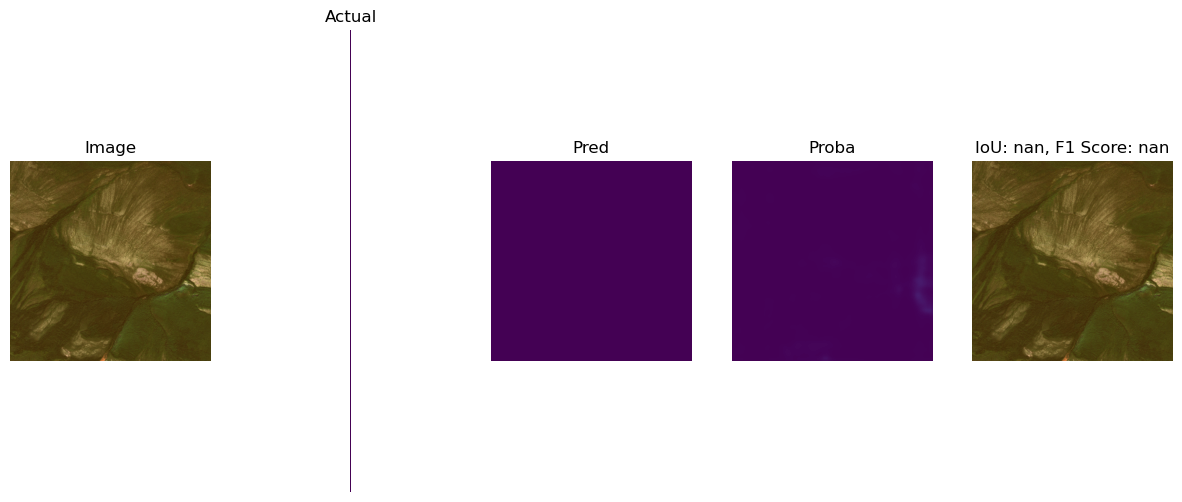

<Figure size 640x480 with 0 Axes>

In [18]:
plot_predictions(images, labels, probas, preds)

In [19]:
batch_size_tile = int((10980/CHIP_SIZE)**2)
batch_size_tile
# there should be 459 chips for one scene
# however, we have only 441 chips (?)

459

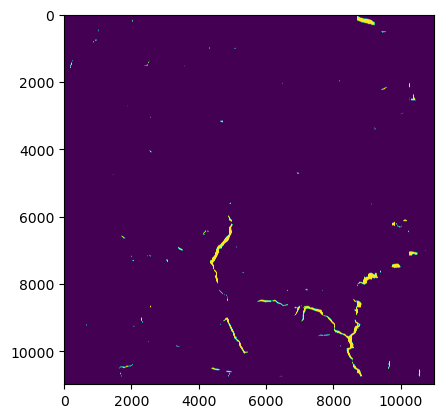

In [20]:
# list all files in the output directory
temp_chips = os.listdir(output_dir)

# extract the chip number
chip_num = [int(chip.split("_")[7].split(".")[0]) for chip in temp_chips]

preds = []

# Iterate over the indices in the batch
for i in range(len(chip_num)):
    index = chip_num.index(i)
    # print(f"Processing chip {temp_chips[index]}")
    # Post-process the results
    # read the prediction
    pred = np.load(f"{output_dir}{temp_chips[index]}")
    preds.append(pred.squeeze())

# Combine the 16 images into a single 2048x2048 image
def put_np_together(images, channels=3, chip_size=512):
    if channels == 1:
        big_image = np.zeros((10980, 10980))
    elif channels == 3:
        big_image = np.zeros((10980, 10980, 3))

    # Define the chip size and the number of chips in each dimension
    chip_size = chip_size
    n_chips_x = 10980 // chip_size
    n_chips_y = 10980 // chip_size

    # Iterate over the 16 images and place them in the correct position
    chip_number = 0
    for i in range(n_chips_x):  # Iterate over columns
        for j in range(n_chips_y):  # Iterate over rows
            x1, y1 = j * chip_size, i * chip_size
            x2, y2 = x1 + chip_size, y1 + chip_size
            if channels == 1:
                big_image[x1:x2, y1:y2] = images[chip_number]
            else:
                big_image[x1:x2, y1:y2, :] = images[chip_number]
            chip_number += 1

    return big_image

big_pred = put_np_together(preds, channels=1, chip_size=CHIP_SIZE)

# plot big_pred
plt.imshow(big_pred)

In [21]:
img_name = file_path.split("/")[-1].split(".")[0]
img_name

'S2B_MSIL2A_20240823T033539_R061_T50VMM_20240823T082315'

In [22]:
import rasterio
from rasterio import features
import geopandas as gpd
from shapely.geometry import shape

# Open the stack geotiff file to get the georeference information
with rasterio.open(file_path) as src:
    profile = src.profile

# Update the profile to match the new data
profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw'
)

# Save the big_pred numpy array as a geotiff file
output_file = 'data/interim/' + img_name + '_pred.tif'
with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(big_pred, 1)

# Convert the numpy array to a raster shapefile
shapes = features.shapes(big_pred.astype(rasterio.uint8), transform=profile["transform"])
geoms = [shape(geom) for geom, value in shapes if value == 1]
gdf = gpd.GeoDataFrame(geometry=geoms)

# Save the GeoDataFrame as a geopackage
output_file = 'data/interim/' + img_name + '_pred.gpkg'
gdf.to_file(output_file, driver='GPKG')

In [23]:
# visualize the geodataframe on a map
